### Biblioteki, stałe i ładowanie danych

In [2]:
import numpy as np
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# from src.db.gateway.gateway import TracksGateway

In [3]:
plt.style.use('seaborn')

In [4]:
# Load df using sqlite
# tracks_gw = TracksGateway()
# df = tracks_gw.fetch_all()
# df.head()

In [5]:
# Load df using .csv
df = pd.read_csv('../data/features.csv')

### Wstępna eksploracja

In [6]:
df.head()

,track_id,title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artists_ids,genres
0,0aQA9DP54h37OevE7hRc2a,NaN,0.653,0.796,7,-4.050,0,0.2450,0.2400,0.00000,0.1080,0.405,160.026,252712,4,"[""6fOMl44jA4Sp5b9PpYCkzz""]","[[""hip hop"", ""pop rap"", ""rap""]]"
1,4ixBAI0E1M6df9mP27etZK,NaN,0.731,0.494,4,-9.567,1,0.0467,0.2010,0.00000,0.1600,0.477,120.045,228056,4,"[""46VwdSiSccsgzNhJP9sGhQ"", ""2272CVpxVafY3L0UHu...","[[""icelandic hip hop"", ""icelandic pop""]]"
2,3jO5IAvslWxaTxswokg66i,NaN,0.859,0.464,3,-7.328,1,0.2890,0.2080,0.00000,0.1140,0.370,134.966,195453,4,"[""2LRoIwlKmHjgvigdNGBHNo"", ""5J7rXWjtn5HzUkJ4Je...","[[""colombian pop"", ""latin"", ""pop reggaeton"", ""..."
3,5iS3TEmmRcDJU2pTJQ98zB,NaN,0.482,0.617,10,-10.288,0,0.0869,0.7750,0.58300,0.1070,0.350,174.040,300861,4,"[""3MaQwUQBigrjcMYHk8bDKm"", ""5Y24oYaTX3VOvtAcG2...","[[""finnish dance pop"", ""finnish hip hop"", ""fin..."
4,29xPIFa0othUcFrEGyJCZu,NaN,0.824,0.684,1,-7.185,1,0.4070,0.0236,0.00853,0.0762,0.509,141.143,186973,4,"[""2s7fZ34RK8RUJQ2ewsh6I5"", ""3tTvSeZiFDP3CY5EdP...","[[""francoton"", ""french hip hop"", ""pop urbaine""..."


In [7]:
df.shape

(54775, 17)

In [8]:
# Max number of tracks take into account
n_total = len(glob.glob('./data/scraped_data/*/*'))*200
print(n_total)

0


**Wstępnie można zaobserwować występowanie tych samych utworów w ramach wielu rankingów.**

In [9]:
n_ranks = {}
country_codes = [path.split('/')[-1] for path in glob.glob('./data/scraped_data/*')]
for country_code in country_codes:
    n_ranks[country_code] = len(glob.glob(f'./data/scraped_data/{country_code}/*'))
    
n_ranks = sorted(n_ranks.items(), key=lambda x: x[1])
n_ranks = dict(n_ranks)

In [10]:
n_ranks

{}

**Informacje o rankingach są niepełne dla takich państw jak Białoruś (3), Indie (158), Emiraty Arabskie (172), Egipt (172) oraz Izrael (208).**

In [11]:
drop_cols = ['track_id', 'title', 'key', 'mode', 
             'time_signature', 'artists_ids', 'genres']
df_numeric = df.drop(drop_cols, axis=1)
features = list(df_numeric.columns)
x = df_numeric.to_numpy()
x = StandardScaler().fit_transform(x)

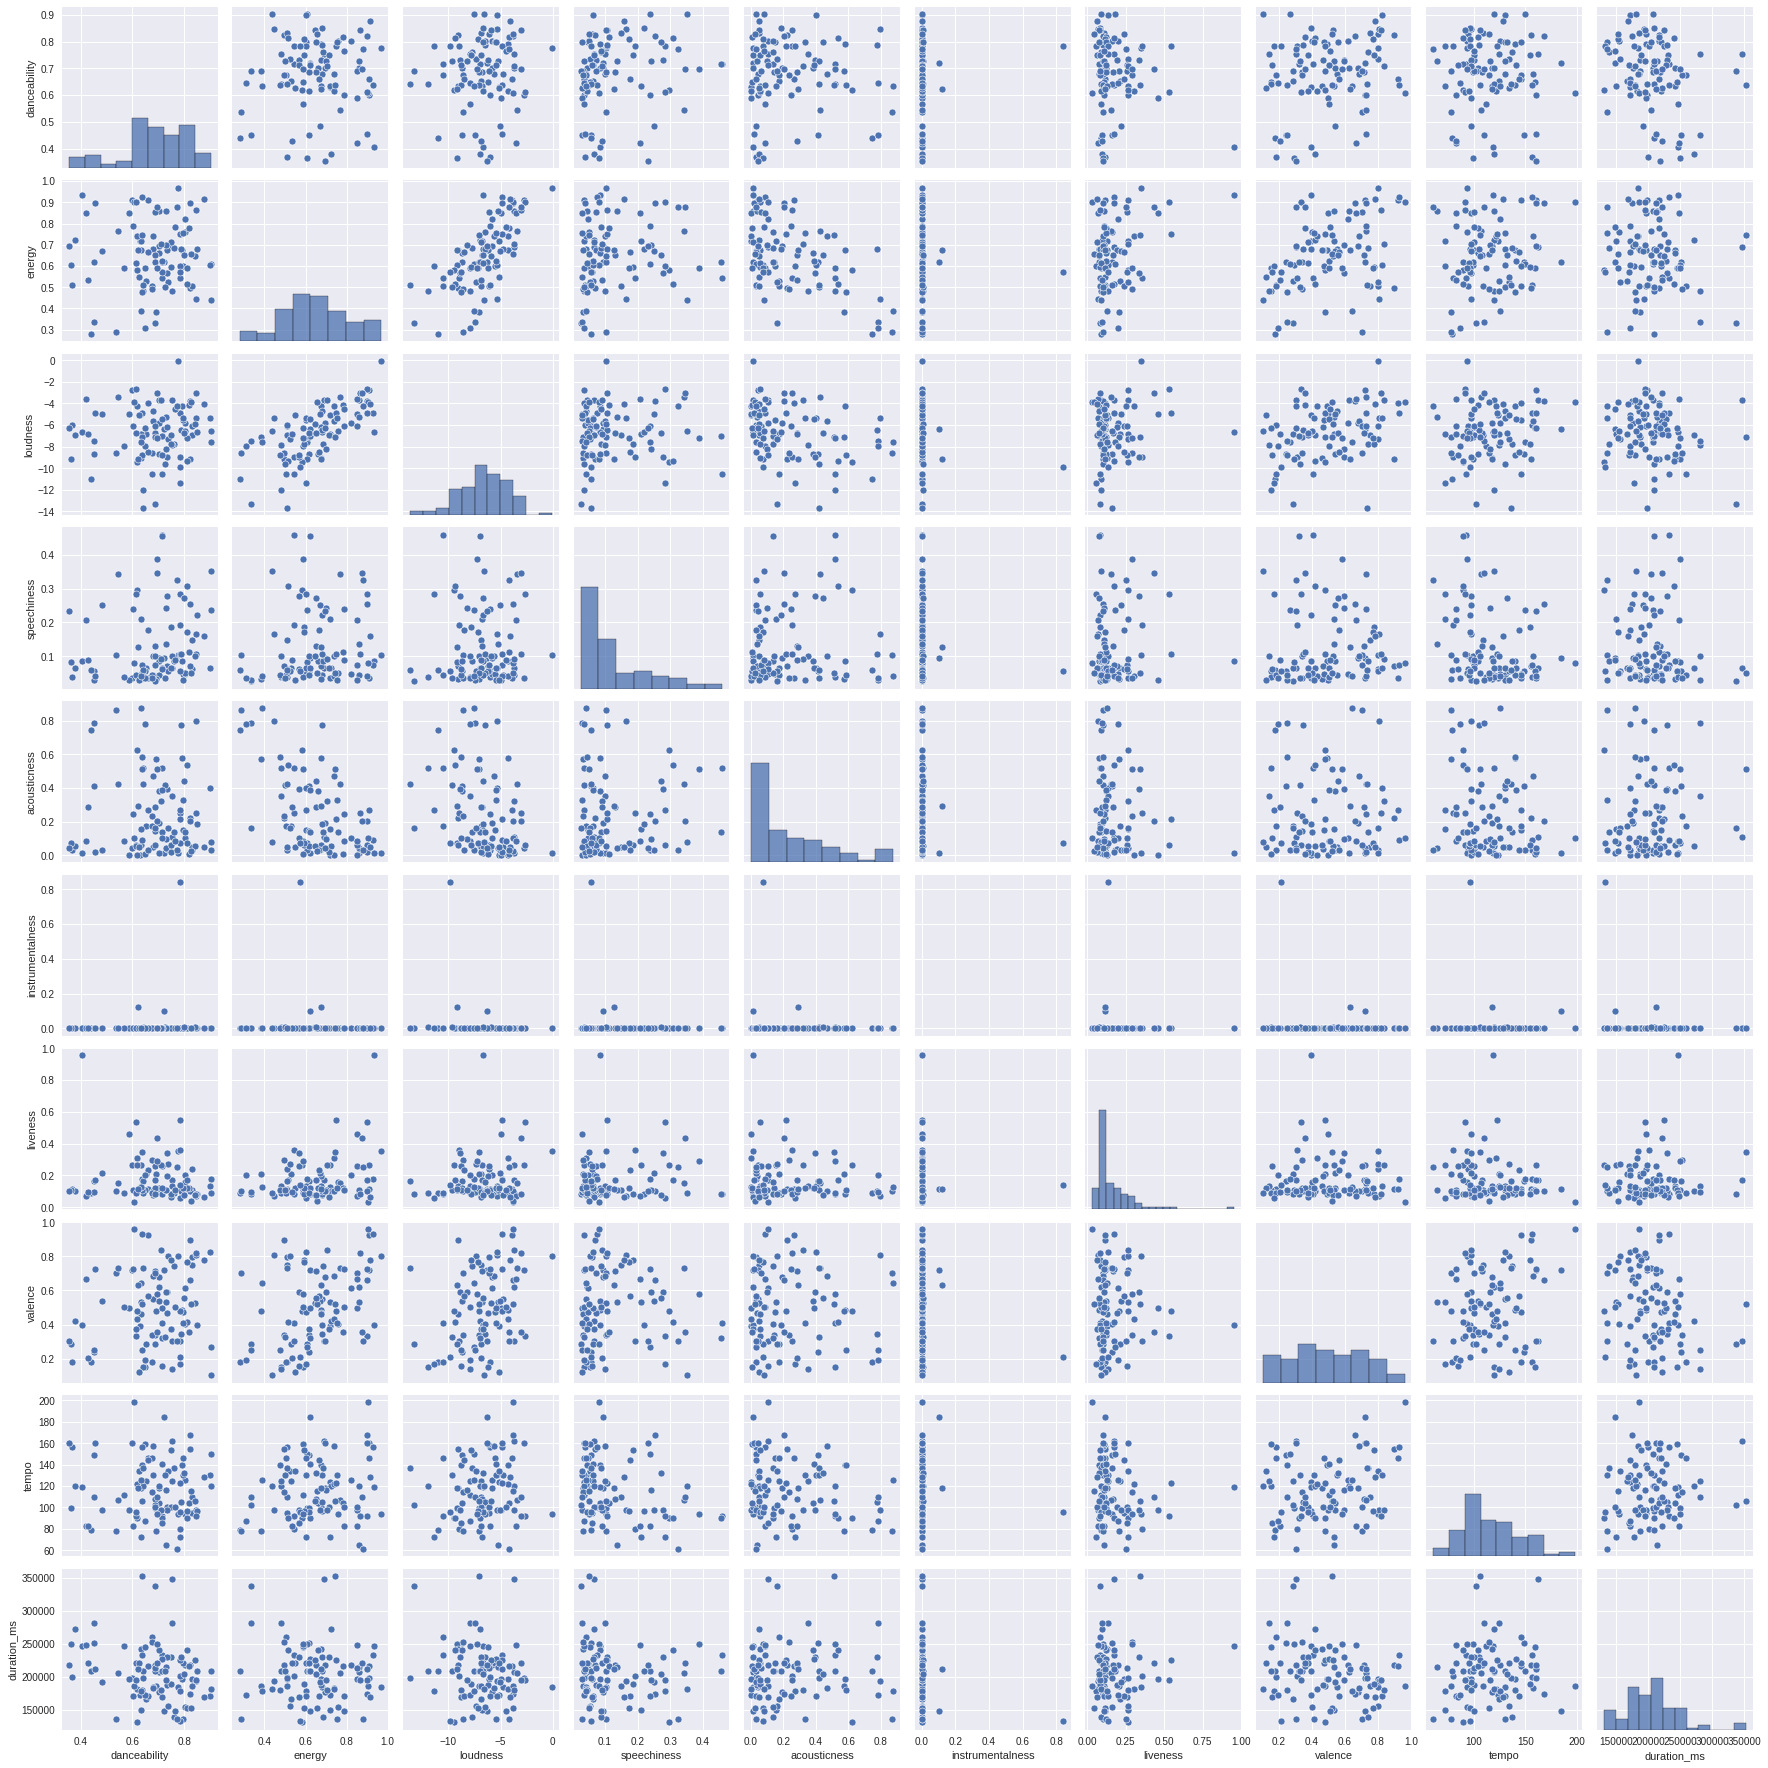

In [12]:
sns.pairplot(df.sample(n=100).drop(drop_cols, axis=1));

**Cechy audio nie są skorelowane (zauważalna korelacja jedynie dla `energy` i `loudness`), charakteryzują się różnymi rozkładami.**

### PCA

In [13]:
pca = PCA()
x_pca = pca.fit_transform(x)

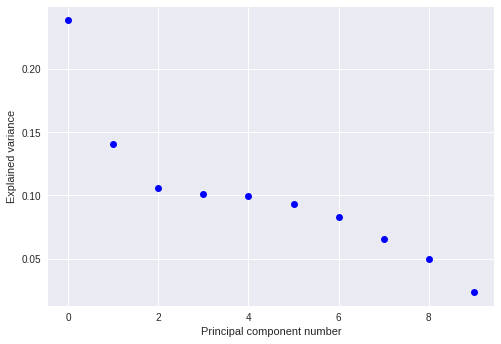

In [14]:
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.xlabel('Principal component number')
plt.ylabel('Explained variance')
plt.show()

**Poszczególne komponenty zachowują względnie dużo informacji - zbiór jest złożony.**

In [15]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
print('Attribute, PC1, PC2')

projected_features = {}

for i in range(0, pc1.shape[0]):
    print(features[i] + ' : ' + repr(pc1[i]) + ' : ' + repr(pc2[i]))
    projected_features[features[i]] = (pc1[i], pc2[i])

Attribute, PC1, PC2
danceability : -0.2677376858999834 : -0.5532716512467409
energy : -0.5537467710514778 : 0.22992532585461198
loudness : -0.518040257043168 : 0.24643219688449575
speechiness : -0.057403243988987884 : -0.4673272714912151
acousticness : 0.40850359019706833 : -0.05991738782917451
instrumentalness : 0.1521488523720193 : 0.07859439267575143
liveness : -0.09774691178109471 : 0.23734669716731144
valence : -0.36787598641681535 : -0.20607861881203
tempo : -0.07910080417951676 : 0.08519805309573684
duration_ms : 0.09408300012447934 : 0.49605794636640893


**Wartości elementów są stosunkowo duże dla wszystkich cech, oprócz cechy `tempo`.**

In [16]:
# Scale component values down for clarity
x_pca[:, 0] /= np.amax(x_pca[:, 0])
x_pca[:, 1] /= np.amax(x_pca[:, 1])

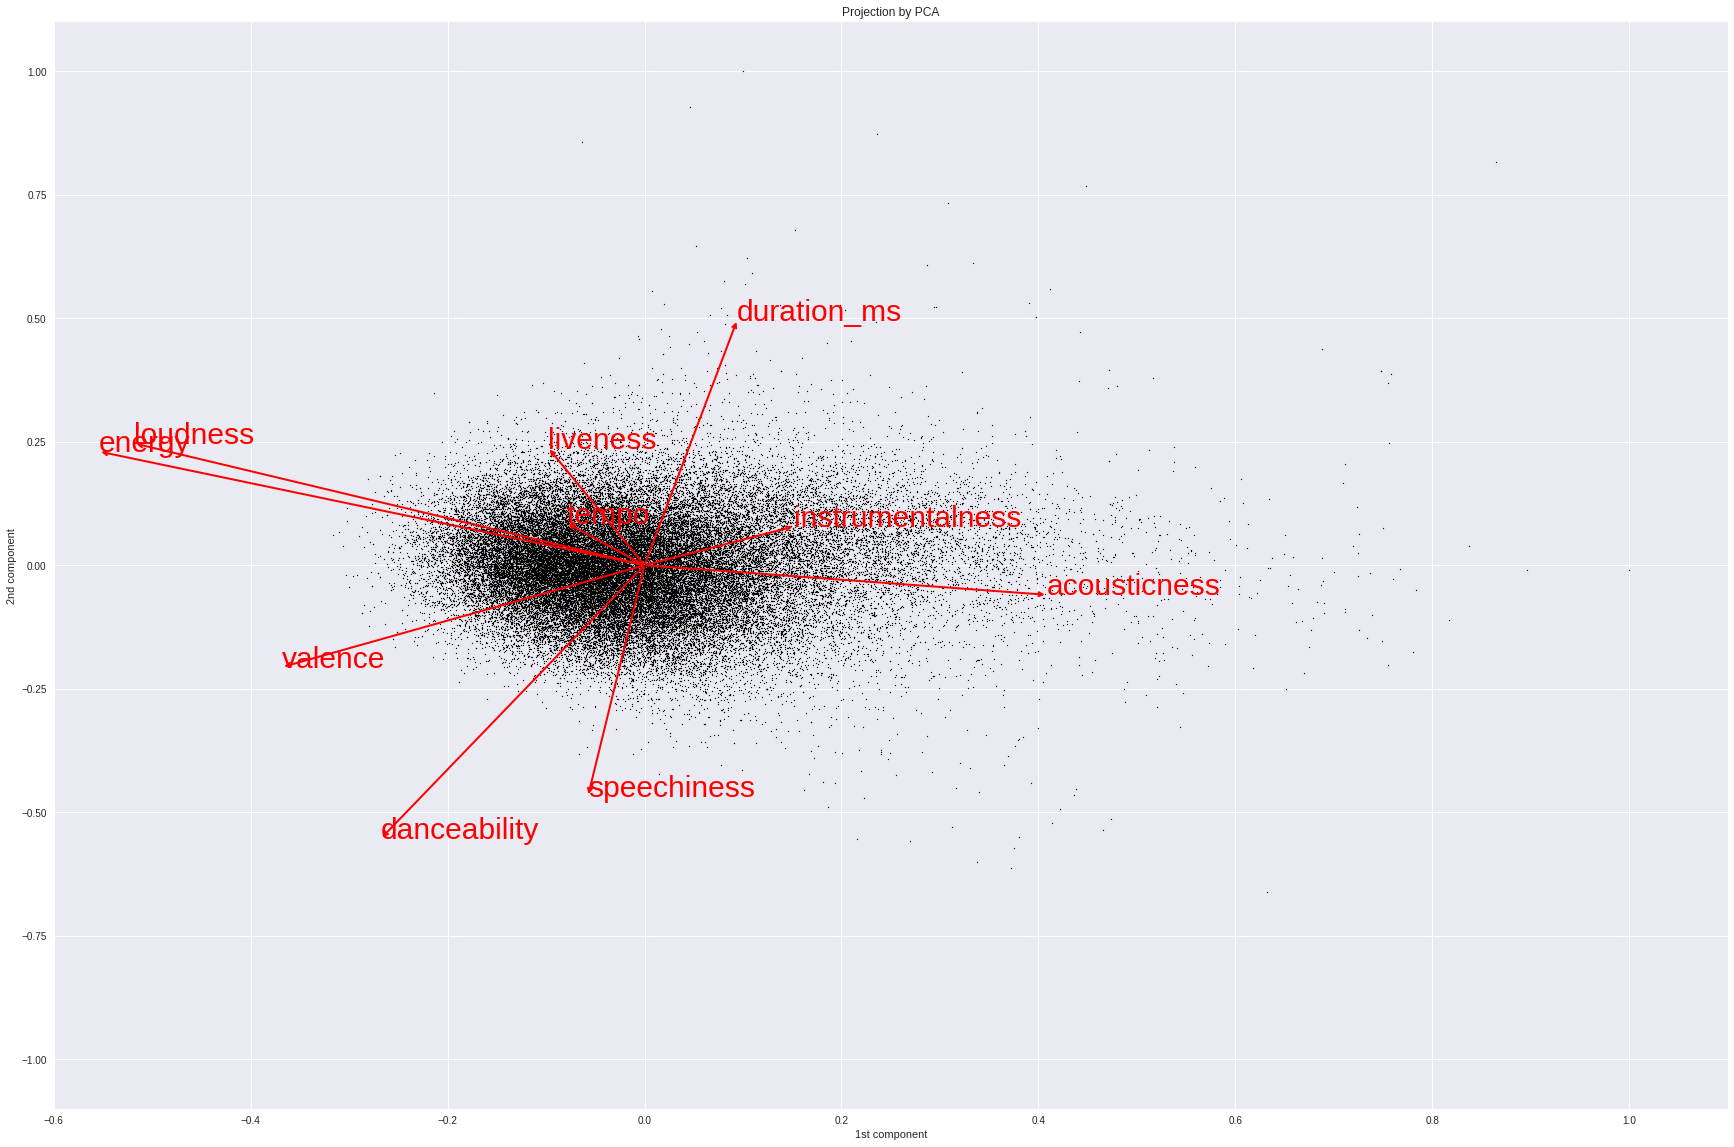

In [17]:
plt.figure(figsize=(30, 20))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c='k', s=1)

for feature_name, coords in projected_features.items():
    plt.annotate('', xy=coords, xytext=(0, 0), arrowprops=dict(arrowstyle='->', color='r', lw=2))
    plt.text(x=coords[0], y=coords[1], s=feature_name, fontsize=30, color='r')

plt.title('Projection by PCA')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.ylim(-1.1, 1.1)
plt.xlim(-0.6, 1.1)
plt.show()

**Przestrzeń jest rozciągana głównie przez to, jak utwory są głośne i energiczne oraz jak bardzo są akustyczne.**

### Zmienność cech w czasie

In [18]:
def aggregate_means_week(csv_path: str, df_features: pd.DataFrame, feature_names: list) -> list:
    df_week = pd.read_csv(csv_path, sep=';')
    df_week_merged = pd.merge(df_week, df_features, on='track_id', how='inner')
    features_week = df_week_merged[features_names].to_numpy()
    features_means = np.mean(features_week, axis=0)
    
    return list(features_means)

In [24]:
features_names = df_numeric.columns
df_means = pd.DataFrame(columns=features_names)
csv_paths = sorted(glob.glob(f'../data/scraped_data/global/*'))

for csv_path in csv_paths:
    week = csv_path.split('/')[-1].split('--')[-2]
    
    week_means = aggregate_means_week(csv_path, df, features_names)
    df_means.loc[week] = week_means

In [25]:
# Scale all to [0, 1] for visualization purposes
scaler = MinMaxScaler()
df_means[df_means.columns] = scaler.fit_transform(df_means.to_numpy())

In [26]:
fig = px.line(df_means, x=df_means.index, y=df_means.columns)
fig.update_layout(
    title='Średnie natężenia cech audio w czasie (rankingi globalne)',
    xaxis_title='Czas',
    yaxis_title='Natężenie cechy')
fig.show()

Obserwacje:

1. Sezonowość (Boże Narodzenie):
* coroczny spadek natężenia taneczności, energii, głośności i niewokalności utworów przed Świętami Bożego Narodzenia (i szybki wzrost przed nowym rokiem), wzrost natężenia akustyczności i pogodności utworów.


2. Trendy:
* spadek taneczności utworów (prawdopodobnie w związku z pandemią);
* spadek stosunku mowy do muzyki (prawdopodobnie z powodu wzrostu popularności podcastów i powstania dedykowanych serwisów);
* wzrost pogodności utworów od początku pandemii;
* spadek średniej długość utworów na przestrzeni ostatnich lat;
* wzrost akustyczności utworów na przestrzeni ostatnich lat.